# Extreme Gradient Boosting Analysis of AllState Data Set

1. Import required libraries.
1. Load preprocessed Kaggle training data and split into training and testing subsets.
1. Define functions to create models and plot feature importances.
1. Initialize XGB hyper-parameters and fit model to training data (find optimal number of trees).
1. Tune XGB hyper-parameters using cross-validation.
1. Compute model performance on training and testing subsets.
1. Refit model with final hyper-parameter settings to entire Kaggle training data set and save model to disk.
1. As an alternative to previous calculations, retrieve model from disk file.
1. Make predictions on Kaggle testing data set and save to file.

In [1]:
'''
Imports
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.externals import joblib
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
from time import strftime
from datetime import datetime

In [2]:
'''
Load preprocessed Kaggle training data set and split it into training and testing subsets.
'''
# Select training set size and preprocessed data file
N_train = 150000
TrainingDataFile = 'data/train_prep1_prob010.pkl'

# Load data and split into training and testing subsets
df0     = pd.read_pickle(TrainingDataFile)
N_test  = len(df0) - N_train
print('Shape of Kaggle training data frame: {0}'.format(df0.shape))
df0_train, df0_test  = train_test_split(df0, test_size=N_test, random_state=0)
print('Shape of df0_train:                  {0}'.format(df0_train.shape))
print('Shape of df0_test:                   {0}'.format(df0_test.shape))

# Make a list of the predictor labels
predictors = [item for item in df0.columns.values if item!="loss"]
target     = "loss"

Shape of Kaggle training data frame: (188318, 325)
Shape of df0_train:                  (150000, 325)
Shape of df0_test:                   (38318, 325)


In [3]:
'''
Define functions to create models and to plot feature importances.
'''

def modelFit(alg, dtrain, predictors, target, CVTrain=True, CVFolds=5, NumCheckRounds=50):
    
    if CVTrain:
        xgb_param = alg.get_xgb_params()
        xgtrain   = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult  = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=CVFolds, 
                           metrics='mae', early_stopping_rounds=NumCheckRounds, verbose_eval=NumCheckRounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='mae')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print('\nModel Report:')
    print('Number of trees = {0}'.format(alg.get_params()['n_estimators']))
    print('            R^2 = {0}'.format(r2_score(dtrain[target].values, dtrain_predictions)))
    print('            MAE = {0}'.format(mean_absolute_error(dtrain[target].values, dtrain_predictions)))
    
    
def plotImportances(alg, save=None):
    
    feat_imp   = pd.Series(alg.booster().get_score(importance_type='weight')).sort_values(ascending=False)
    n_features = min(50,len(feat_imp))
    bins       = np.arange(n_features)
    x_labels   = feat_imp.index.values[:n_features]
    y_values   = feat_imp.values[:n_features]
    maxHeight  = 1.10*max(y_values)

    fig, axes  = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
    axes.bar(bins, y_values, align="center", color="lightblue", alpha=0.5)
    axes.set_xticks(bins)
    axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=14)
    axes.set_xlim([-0.5,bins.size-0.5])
    axes.set_xlabel('Top {0} Features'.format(n_features), fontsize=20)
    axes.set_ylim([0.0, maxHeight])
    axes.set_ylabel('Feature Importance Score', fontsize=20)
    par_names = ['n_estimators', 'max_depth', 'min_child_weight', 'gamma', 
                 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']
    outstring = '\n'.join([key+': {'+str(ind)+'}' for (ind,key) in enumerate(par_names)])
    par_vals  = map(alg.get_params().__getitem__, par_names)
    axes.text(0.79, 0.50, outstring.format(*par_vals), fontsize=20, transform=axes.transAxes)
    plt.show()
    if save is not None: fig.savefig(save, dpi=200, bbox_inches='tight')

[0]	train-mae:3009.89+3.26101	test-mae:3009.88+13.0919
[50]	train-mae:1902.91+2.89708	test-mae:1903.58+10.8759
[100]	train-mae:1478.29+3.24382	test-mae:1481.31+6.65484
[150]	train-mae:1343.57+3.20758	test-mae:1349.39+4.5305
[200]	train-mae:1301.02+3.41788	test-mae:1309.54+3.53195
[250]	train-mae:1283.14+3.04663	test-mae:1294.29+3.28074
[300]	train-mae:1270.87+2.6018	test-mae:1284.27+2.97256
[350]	train-mae:1259.9+2.38842	test-mae:1275.19+3.23643
[400]	train-mae:1249.36+2.10171	test-mae:1266.4+3.5575
[450]	train-mae:1239.08+1.92083	test-mae:1257.82+3.64361
[500]	train-mae:1229.67+1.90149	test-mae:1250.04+3.72927
[550]	train-mae:1221.13+1.88887	test-mae:1243.01+3.59424
[600]	train-mae:1213.59+1.76348	test-mae:1236.92+3.6257
[650]	train-mae:1206.94+1.72903	test-mae:1231.54+3.56088
[700]	train-mae:1200.96+1.70598	test-mae:1226.85+3.51225
[750]	train-mae:1195.77+1.65581	test-mae:1222.84+3.53759
[800]	train-mae:1191.25+1.53136	test-mae:1219.52+3.61121
[850]	train-mae:1187.2+1.45567	test-mae:

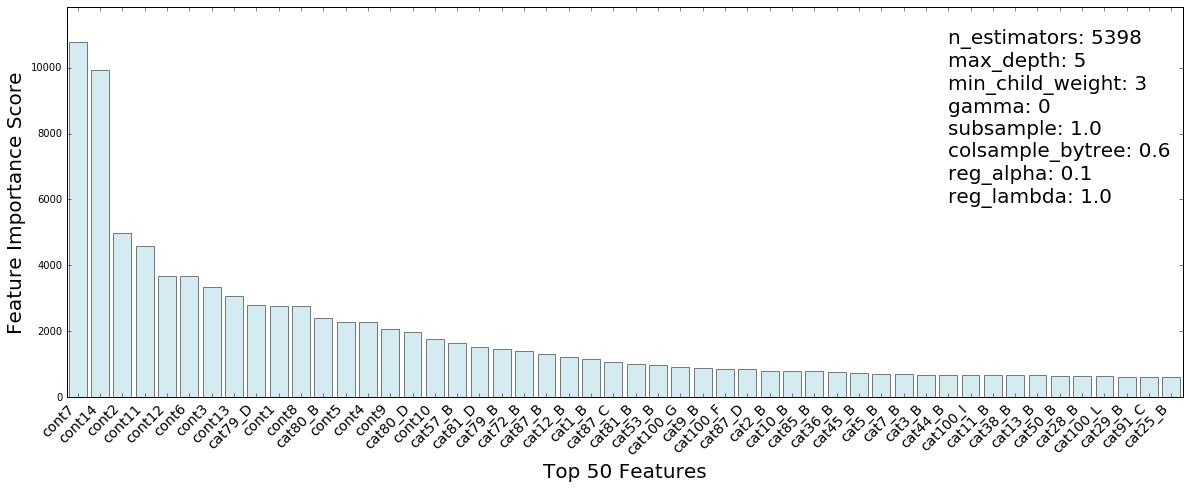

In [4]:
'''
Initialize XGB parameters, then optimize number of trees by cross-validation.
'''

%matplotlib inline

defaults = {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01,
            'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 3, 'missing': np.nan, 'n_estimators': 10000,
            'nthread': -1, 'objective': 'reg:linear', 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'scale_pos_weight': 1,
            'seed': 0, 'silent': True, 'subsample': 1.0}

xgb1 = XGBRegressor(**defaults)
%time modelFit(xgb1, df0_train, predictors, target, CVTrain=True)
defaults.update(xgb1.get_params())
plotImportances(xgb1)

In [ ]:
'''
Tune various XGB hyper-parameters by cross-validating over a set of grids.
'''

searchGrids = [{'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}, 
               {'gamma': [0.0,0.1,0.2,0.3,0.4]},
               {'subsample': [0.9,0.95,1.00], 'colsample_bytree': [0.5,0.55,0.6]},
               {'reg_alpha': [1.0E-05, 1.0E-02, 0.1, 1.0, 100.0]},
               {'reg_lambda': [0.01, 0.1, 1.0, 10.0, 100.0]}]

for grid in searchGrids:
    gSearch = GridSearchCV(estimator=XGBRegressor(**defaults), param_grid=grid, 
                           scoring='neg_mean_absolute_error', n_jobs=-1, iid=False, cv=5, refit=True)
    %time gSearch.fit(df0_train[predictors], df0_train[target])
    defaults.update(gSearch.best_params_)
    print('Updated parameters: {0}, best score: {1}'.format(gSearch.best_params_, gSearch.best_score_))
    
xgb1 = gSearch.best_estimator_
print('\n{0}'.format(xgb1))

All output directed to files with name "xgb_2017_02_11_23_27_12"

Model Report
Algorithm: XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=20, nthread=-1,
       objective='reg:linear', reg_alpha=1e-05, reg_lambda=0.01,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.95)
On training set: R^2 = -0.60756391124
                 MAE = 2494.85842822
On testing set:  R^2 = -0.620581063871
                 MAE = 2487.88133461


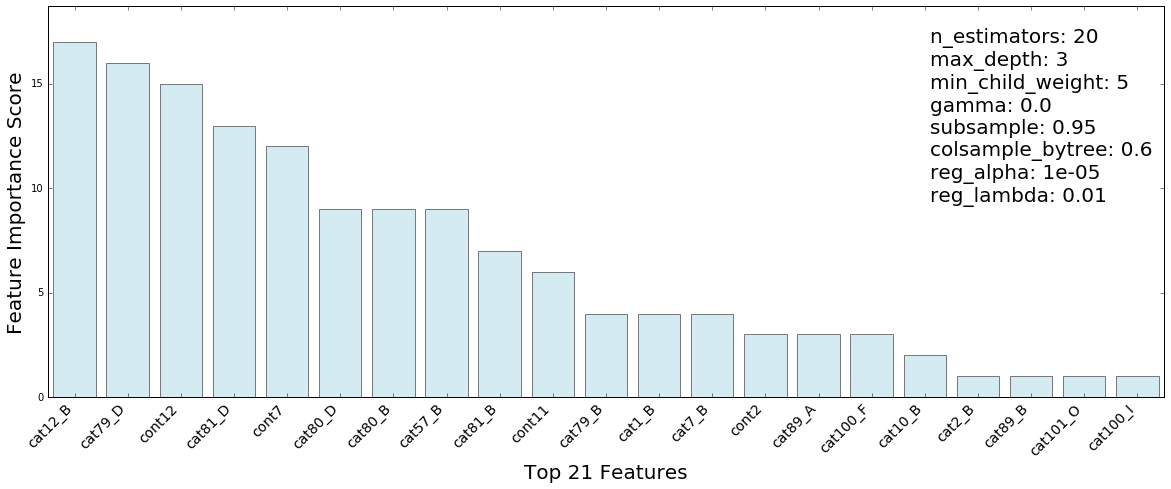

In [6]:
'''
Compute performance on training and testing sets.
'''

%matplotlib inline

# Create output file name
fName = 'xgb_' + strftime("%Y_%m_%d_%H_%M_%S")
print('All output directed to files with name "{0}"'.format(fName))

# Predict training set and testing set
df0_train_predictions = xgb1.predict(df0_train[predictors])
df0_test_predictions  = xgb1.predict(df0_test[predictors])

# Print model report
print('\nModel Report')
print('Algorithm: {0}'.format(xgb1))
print('On training set: R^2 = {0}'.format(r2_score(df0_train[target].values, df0_train_predictions)))
print('                 MAE = {0}'.format(mean_absolute_error(df0_train[target].values, 
                                                              df0_train_predictions)))
print('On testing set:  R^2 = {0}'.format(r2_score(df0_test[target].values, df0_test_predictions)))
print('                 MAE = {0}'.format(mean_absolute_error(df0_test[target].values, 
                                                              df0_test_predictions)))
with open(fName+'.results', 'w') as outf:
    print >>outf, 'Logging time: {0}'.format(datetime.now().isoformat())
    print >>outf, 'Preprocessed data file: {0}'.format(TrainingDataFile)
    print >>outf, 'Algorithm: {0}'.format(xgb1)
    print >>outf, 'On training set: R^2 = {0}'.format(r2_score(df0_train[target].values, df0_train_predictions))
    print >>outf, '                 MAE = {0}'.format(mean_absolute_error(df0_train[target].values, 
                                                                          df0_train_predictions))
    print >>outf, 'On testing set:  R^2 = {0}'.format(r2_score(df0_test[target].values, df0_test_predictions))
    print >>outf, '                 MAE = {0}'.format(mean_absolute_error(df0_test[target].values, 
                                                                          df0_test_predictions))

# Plot feature importances
plotImportances(xgb1, save=fName+'.fi.png')

[0]	train-mae:3006.49+4.91126	test-mae:3006.49+19.8405

Model Report:
Number of trees = 20
            R^2 = -0.622862785615
            MAE = 2488.9113775
CPU times: user 3min 1s, sys: 29 s, total: 3min 30s
Wall time: 3min 39s
Extreme gradient boosting model saved to fitted_models/xgb_2017_02_11_23_27_12.model


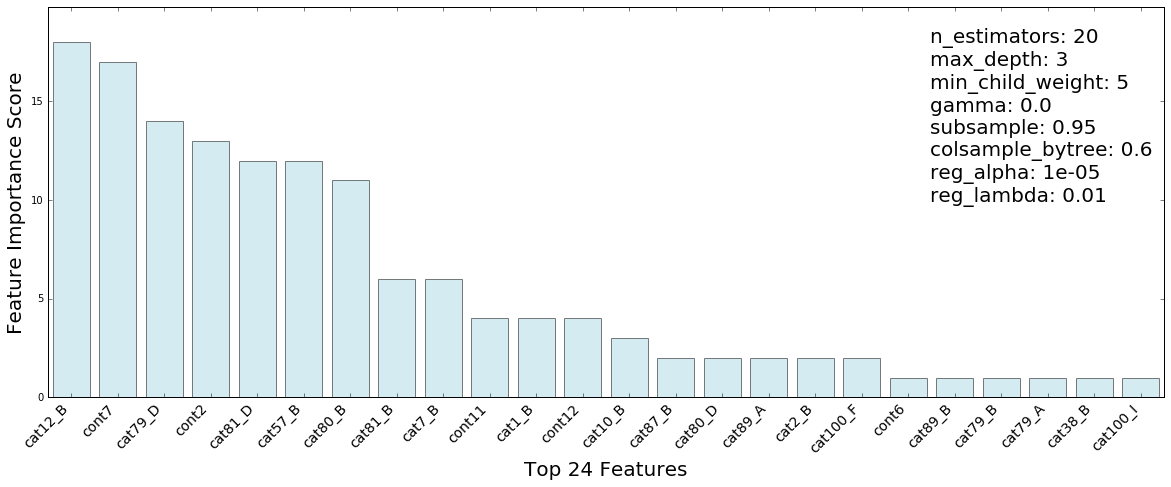

In [7]:
'''
Refit model with final settings to entire Kaggle training data set,
and save fitted model to disk.
'''

%matplotlib inline

xgb2 = XGBRegressor(**defaults)
%time modelFit(xgb2, df0, predictors, target, CVTrain=True)
defaults.update(xgb2.get_params())

path_to_file = 'fitted_models/'+fName+'.model'
joblib.dump(xgb2, path_to_file)
print('Extreme gradient boosting model saved to {0}'.format(path_to_file))

plotImportances(xgb2)

In [9]:
'''
Retrieve trained model from disk. Only run this cell if previous one wasn't run.
Note that by default the file name encodes a date and time, to the second.
'''

if xgb2 is None:
    fName = 'xgb_2017_02_11_17_23_19'
    path_to_file = 'fitted_models/'+fName+'.model'
    xgb2 = joblib.load(path_to_file) 
    print('File {0} successfully loaded\n'.format(path_to_file))    
else:    
    print('Fitted model already exists, not updated from file!\n')

print xgb2

Fitted model already exists, not updated from file!

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=20, nthread=-1,
       objective='reg:linear', reg_alpha=1e-05, reg_lambda=0.01,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.95)


In [10]:
'''
Make predictions on Kaggle testing data set and output to file.
'''

# Load the testing data file that corresponds to the training data file we used.
TestingDataFile = TrainingDataFile.replace('train', 'test')
df1 = pd.read_pickle(TestingDataFile)

# Compute predictions.
print('Shape of competition test data frame: {0}'.format(df1.shape))
y_competition_pred = xgb2.predict(df1[predictors])
df_competition     = pd.Series(y_competition_pred, index=df1.index)

# Output to file.
path_to_file = 'data/'+fName+'.csv'
try:
    df_competition.to_csv(path=path_to_file, sep=',', header=['loss'], index=True, index_label=['id'])
    print('Extreme gradient boosting predictions successfully saved to {0}'.format(path_to_file))
except:
    print('!Error saving extreme gradient boosting predictions to {0}'.format(path_to_file))

Shape of competition test data frame: (125546, 325)
Extreme gradient boosting predictions successfully saved to data/xgb_2017_02_11_23_27_12.csv
